In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transforms3d as t3d
import itertools
from tqdm import tqdm

In [2]:
#good optimizers:
#https://nlopt.readthedocs.io/en/latest/
#pagmo / pygmo

#mystic might be the best: https://github.com/uqfoundation/mystic 
#http://trac.mystic.cacr.caltech.edu/project/mystic/wiki.html

In [3]:
from sklearn.metrics import mean_squared_error

def convert_quat_and_cart_to_homogeneous(q, xyz):
    T = np.eye(4)
    T[:3,:3] = t3d.quaternions.quat2mat(q)
    T[:3,3] = xyz
    return T

def generate_random_homogeneous_transform():
    q = np.random.dirichlet([1.3, 1.3, 1.3, 1.3], size = 1).squeeze()
    xyz = np.random.rand(3)
    return convert_quat_and_cart_to_homogeneous(q, xyz)

def list_permuter(list1, list2):
    #subitem for item in a for subitem in (item if isinstance(item, list) else [item])
    return [[subitem for item in pair for subitem in (item if isinstance(item, list) else [item])] for
            pair in itertools.product(list1,list2)]



In [4]:
#define all the points of the object
alpha = 0.05

point_positions = np.array([[1, -1, 0],[-1, -1, 0], [-1, 1, 0],[1, 0, -1],[-np.cos(np.pi/3), -np.sin(np.pi/3), -1],
                            [-np.cos(np.pi/3), np.sin(np.pi/3), -1]]).T

point_positions = point_positions * 25.4

point_positions_noisy = point_positions + np.random.normal(loc=0.0, scale=alpha, size = point_positions.shape)

In [5]:
T = generate_random_homogeneous_transform()

point_positions = np.vstack([point_positions, np.ones(6)])
point_positions_noisy = np.vstack([point_positions_noisy, np.ones(6)])
point_positions_noisy_transformed = T @ point_positions_noisy

point_permutations = np.array(list(itertools.permutations(list(range(6)), 6)))

In [6]:
print(point_positions_noisy_transformed[:,point_permutations[0,:]])
print(point_positions_noisy_transformed[:,point_permutations[1,:]])

[[  6.91846468 -25.08694398  -5.8229602   -0.58032619 -33.02142072
  -16.29572746]
 [ 33.83079813  -3.19212072 -33.20179198  27.87789213  12.9635078
  -12.90009636]
 [-11.33178091 -24.66898717  11.65979501  23.28856461  -2.52349564
   28.93890671]
 [  1.           1.           1.           1.           1.
    1.        ]]
[[  6.91846468 -25.08694398  -5.8229602   -0.58032619 -16.29572746
  -33.02142072]
 [ 33.83079813  -3.19212072 -33.20179198  27.87789213 -12.90009636
   12.9635078 ]
 [-11.33178091 -24.66898717  11.65979501  23.28856461  28.93890671
   -2.52349564]
 [  1.           1.           1.           1.           1.
    1.        ]]


In [19]:
point_positions_noisy_transformed[0:3,:] - point_positions_noisy_transformed[0:3,0,None].repeat(6,axis=1) 



array([[  0.        , -37.04723667, -50.76651019, -49.36142105,
        -37.46179573,   0.87434147],
       [  0.        , -25.69112918,   0.4429512 ,   0.90420917,
        -26.09771512, -26.29564081],
       [  0.        , -48.75635196,  -1.60642665, -52.43259662,
         -4.60483183, -26.03838797]])

In [14]:
centroids = np.load('centroids.npy')
centroids = np.vstack([centroids.T, np.ones(6)])
point_positions_noisy_transformed = np.array([centroids[0,:], centroids[1,:], -centroids[2,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])

In [11]:
from scipy.optimize import minimize

# generate quaternion and xyz translation vector
# constraints: ||q|| = 1, |xyz| < 10
# loss: loss(point_positions, convert_quat_and_cart_to_homogeneous(q,xyz)@point_positions_noisy)
def objective(quat_xyz, point_positions, observed_point_positions):
    #returns MSE between points
    q = quat_xyz[0:4]
    xyz = quat_xyz[4:]
    T = convert_quat_and_cart_to_homogeneous(q,xyz)
    return mean_squared_error(T@point_positions, observed_point_positions)

def eq_constraint(quat_xyz):
    return np.sum(quat_xyz[:4]) - 1

results = []
error = []
for i in tqdm(range(point_permutations.shape[0])):
    result = minimize(objective, x0 = np.array([0,0,0,1,0,0,0]), args=(point_positions, point_positions_noisy_transformed[:,point_permutations[i,:]]), method = 'SLSQP', constraints={"fun": eq_constraint, "type": "eq"})
    #print(result)
    results.append(result)
    error.append(result['fun'])
error = np.array(error)



100%|██████████| 720/720 [01:21<00:00,  8.86it/s]


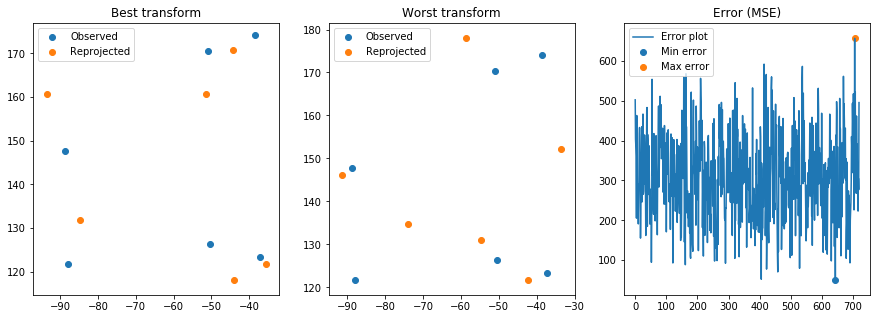

In [12]:
plt.rcParams['figure.figsize'] = [15, 5]

min_error = np.amin(error)
min_error_index = np.argmin(error)
max_error = np.amax(error)
max_error_index = np.argmax(error)

quat_xyz = results[min_error_index]['x']
T = convert_quat_and_cart_to_homogeneous(quat_xyz[:4], quat_xyz[4:])

quat_xyz_worst = results[max_error_index]['x']
T_worst = convert_quat_and_cart_to_homogeneous(quat_xyz_worst[:4], quat_xyz_worst[4:])

plt.figure()
plt.subplot(1,3,1)
plt.scatter(point_positions_noisy_transformed[0,:], point_positions_noisy_transformed[2,:])
plt.scatter((T@point_positions)[0,:], (T@point_positions)[2,:])
plt.legend(['Observed', 'Reprojected'])
plt.title('Best transform')

plt.subplot(1,3,2)
plt.scatter(point_positions_noisy_transformed[0,:], point_positions_noisy_transformed[2,:])
plt.scatter((T_worst@point_positions)[0,:], (T_worst@point_positions)[2,:])
plt.legend(['Observed', 'Reprojected'])
plt.title('Worst transform')

plt.subplot(1,3,3)
plt.plot(error)
plt.title('Error (MSE)')
plt.scatter([min_error_index], [min_error])
plt.scatter([max_error_index], [max_error])
plt.legend(['Error plot','Min error', 'Max error'])
plt.savefig('image_alignment_test.png', bbox_inches='tight')

plt.show()



In [13]:
results[min_error_index]

     fun: 51.272798838772424
     jac: array([ 0.01394081,  0.01426172,  0.01382685,  0.01389027,  0.00769901,
       -0.00288486,  0.02139521])
 message: 'Optimization terminated successfully.'
    nfev: 776
     nit: 82
    njev: 82
  status: 0
 success: True
       x: array([  -48.66071836,  -653.48380621, -3400.8717358 ,  4104.01626038,
         -64.58279153,   166.69208132,   141.19109397])

In [44]:
print((T@point_positions))

[[191.64069101 192.05932444 192.24353003 166.33382328 166.568035
  166.72756171]
 [170.00733542 119.8283411  127.73785554 173.76966724 132.71050128
  139.56034172]
 [ 33.40261143  41.31040979  91.49054181  58.61624475  42.81845897
   86.27572806]
 [  1.           1.           1.           1.           1.
    1.        ]]


In [43]:
centroids

array([[ 87.94611307,  50.8988764 ,  37.17960289,  38.58469203,
         50.48431734,  88.82045455],
       [192.05172018, 166.360591  , 192.49467138, 192.95592935,
        165.95400506, 165.75607937],
       [121.69589517, 170.45224713, 123.30232181, 174.12849178,
        126.300727  , 147.73428313],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ]])